In [429]:
import cv2 as cv
import numpy as np
import inspect
import copy
from matplotlib import pyplot as plt
from utils import Splitter
import math
from numpy import uint8

TEST_IMG = "test.jpeg"

In [430]:
src = cv.imread(TEST_IMG)
if src is None:
    print('Could not open or find the image:', TEST_IMG)
    exit(0)

img = src.copy()
r_split, c_split, split_size = 3, 2, 125
splits = Splitter(img, r_split, c_split, split_size)


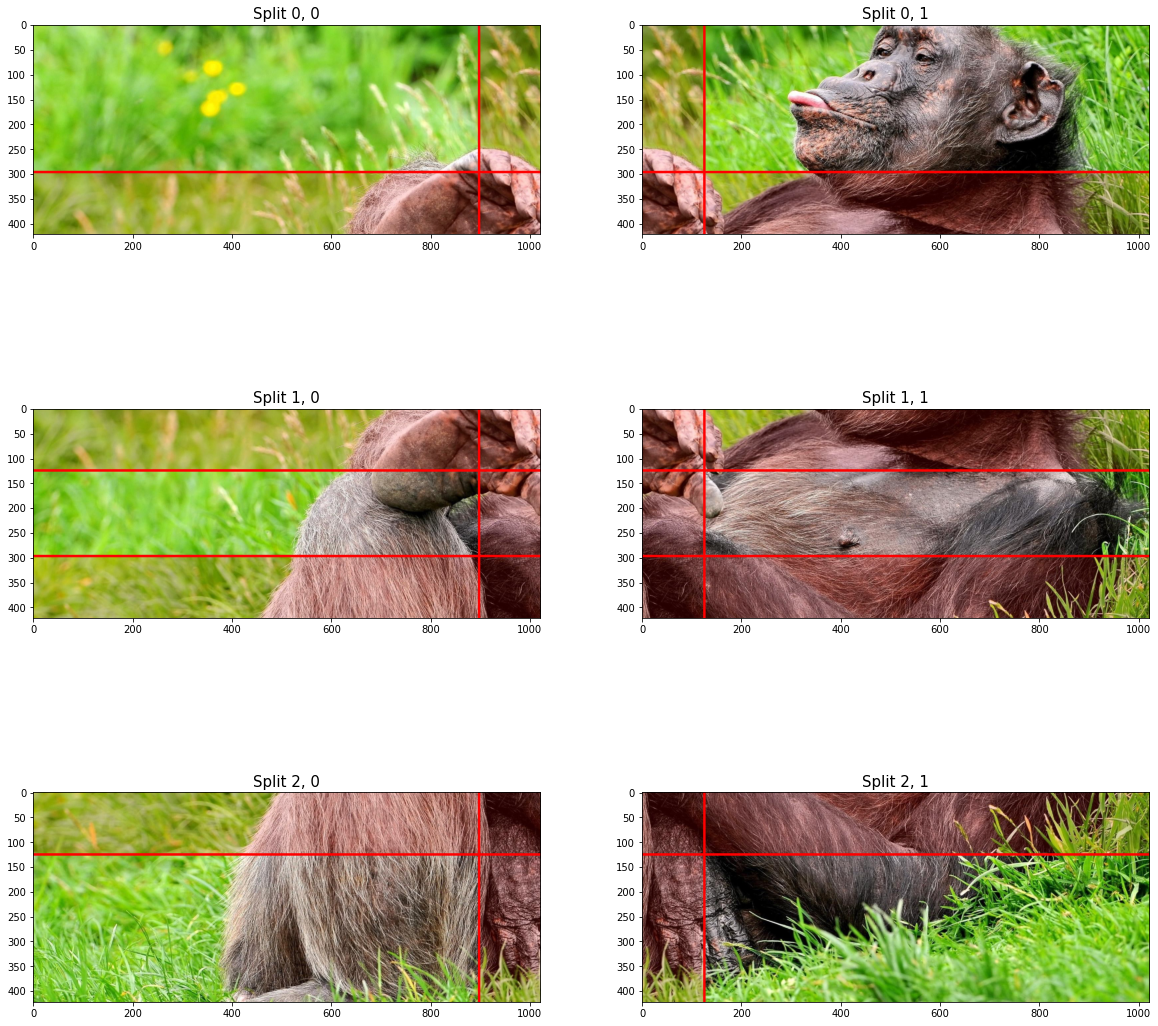

In [431]:
splits.draw_splits(rects=True, alpha=0.15, mod_orig=True)
splits.draw_splits(mod_orig=True)
splits.show()

In [519]:
def apply_SIFT(img, min_s=0, flags=cv.DrawMatchesFlags_DEFAULT, color=-1):
    sift = cv.SIFT_create()
    # gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    gray = img.copy()
    kp, des = sift.detectAndCompute(gray, None)
    kp_des = [v for v in zip(kp, des) if v[0].size >= min_s]
    # [(k, d),(k, d)]
    [kp, des] = zip(*kp_des)
    img = cv.drawKeypoints(
        gray, kp, img, color=color,
        flags=flags
    )

    return img, (kp, np.array(des))

def register(sift_data, split1, split2, thresh=0.5):
    (y1, x1), (y2, x2) = split1.shape[:2], split2.shape[:2]
    if y1 > y2:
        padimg = np.full_like([], 255, shape=(y1, x2, 3), dtype=uint8)
        padimg[0:y2] = split2
        split2 = padimg
    elif y2 > y1:
        padimg = np.full_like([], 255, shape=(y2, x1, 3), dtype=uint8)
        padimg[0:y1] = split1
        split1 = padimg

    [(kp1, des1), (kp2, des2)] = sift_data
    bf = cv.BFMatcher()
    matches = bf.knnMatch(des1, des2, k=2)

    # Apply ratio test
    matches = np.array(
        [[m] for m, n in matches if m.distance < thresh * n.distance]
    )
    
    # can use mask on split region
    reg = cv.drawMatchesKnn(
        split1, kp1,
        split2, kp2,
        matches, None,
        matchColor = (0, 0, 255),
        flags = cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
    )

    if len(matches[:, 0]) >= 5:
        src = np.float32(
            [kp1[m.queryIdx].pt for m in matches[:,0]]).reshape(-1,1,2)
        dst = np.float32(
            [kp2[m.trainIdx].pt for m in matches[:,0]]).reshape(-1,1,2)
        H, _ = cv.findHomography(src, dst, cv.RANSAC, 5.0)
    else:
        raise AssertionError("Not enough matches")

    return reg, H

def blend(H, split1, split2):
    warped = cv.warpPerspective(
        split1, H, (split2.shape[1] + split1.shape[1], split2.shape[0])
    )
    # warped[0:split2.shape[0], 0:split2.shape[1]] = split2

    return warped

Show Affine Invariance

In [520]:
def apply_scale(img, limit=0.25):
    scale = 1 + np.random.uniform(-limit, limit)
    scale = np.array([scale, scale])
    scale *= img.shape[:2]
    return cv.resize(img, scale.astype(int)[::-1])

In [521]:
def padimg(img):
    (y, x) = img.shape[:2]
    cx, cy = x / 2.0, y / 2.0
    px = math.ceil(math.sqrt(cx ** 2 + cy ** 2)) - int(cx)
    py = math.ceil(math.sqrt(cx ** 2 + cy ** 2)) - int(cy)
    shape = tuple(map(lambda i, j: (i + 2 * j), img.shape, (py, px, 0)))
    outimg = np.full_like([], 255, shape=shape, dtype=uint8)
    outimg[py:-py:, px:-px] = img

    return outimg

def rotation(img, theta=None):
    if theta is None:
        theta = np.random.uniform(-180, 180, 1)[0]
    outimg = padimg(img)
    (y, x) = outimg.shape[:2]
    c = (x // 2, y // 2)

    T = cv.getRotationMatrix2D(c, theta, 1.0)
    img = cv.warpAffine(outimg, T, (x, y), borderValue=(255,255,255))
    return img

In [522]:
def shear(img, limit: tuple[float, float]=(0.5, 0.5)):
    sx = np.random.uniform(-limit[0], limit[0])
    sy = np.random.uniform(-limit[1], limit[1])
    (y, x) = img.shape[:2]
    M = np.float32([
        [1, sy, abs(sy) * y if sy < 0 else 0],
        [sx, 1, abs(sx) * x if sx < 0 else 0]
        ]
    )
    s = (int(x + abs(sy) * y), int(y + abs(sx) * x))
    img = cv.warpAffine(img, M, s, borderValue=(255,255,255))
    return img

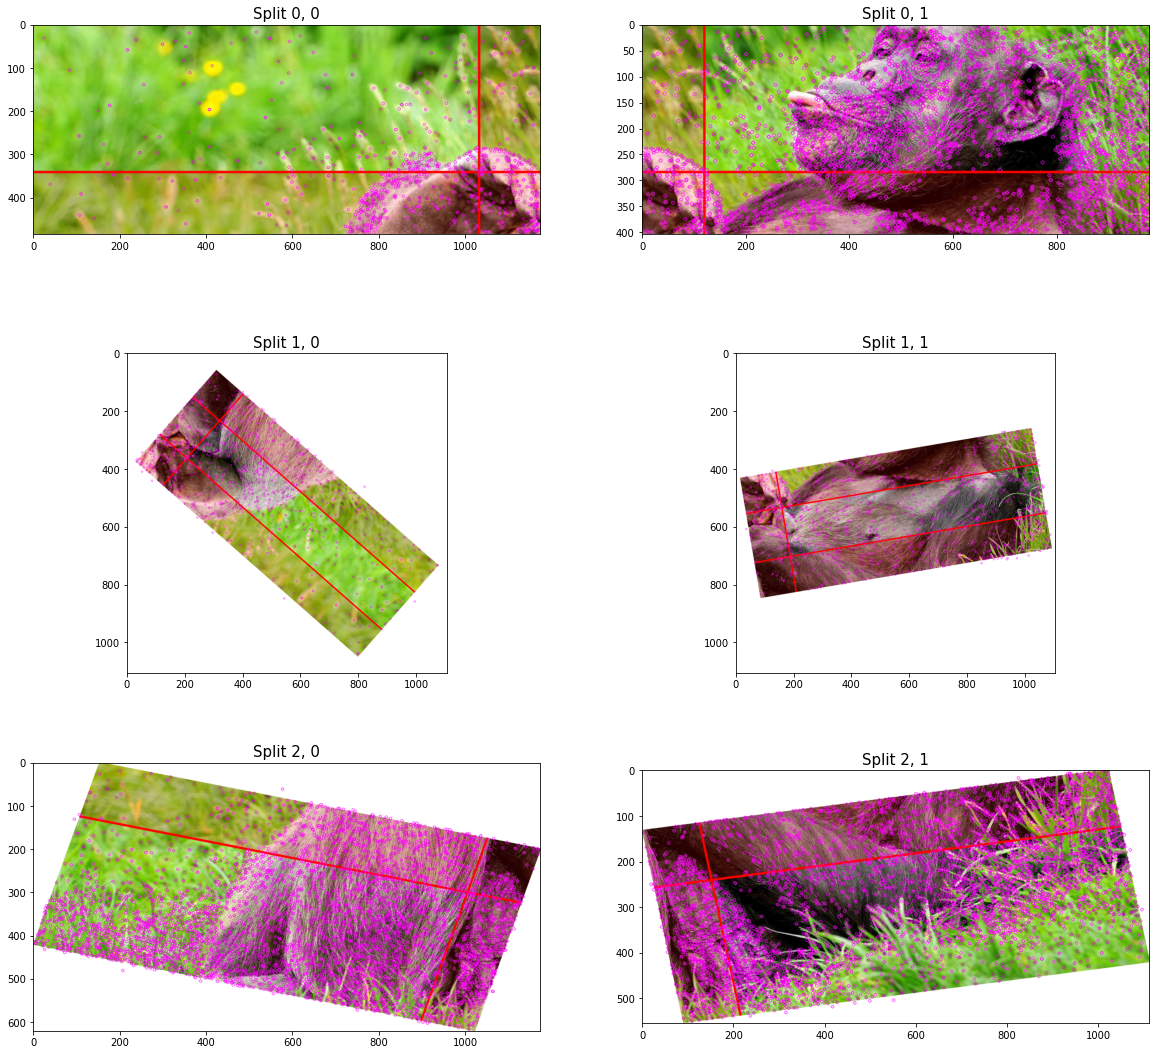

In [532]:
params = {"color": (255, 0, 255),}
splits.restore()

# Scale
splits.apply(apply_scale, range(0,1), range(0,2),)
sift_data0 = splits.apply(apply_SIFT,
    range(0,1), range(0,2),
    thresh=0.8, **params,
)

# Rotation
splits.apply(rotation, range(1,2), range(0,2))
sift_data1 = splits.apply(apply_SIFT,
    range(1,2), range(0,2),
    thresh=0.2, min_s=3, **params,
)

# Shear
splits.apply(shear, range(2,3), range(0,2))

sift_data2 = splits.apply(apply_SIFT,
    range(2,3), range(0,2),
    thresh=0.9, **params
)
sift_data = [sift_data0, sift_data1, sift_data2]

splits.show()

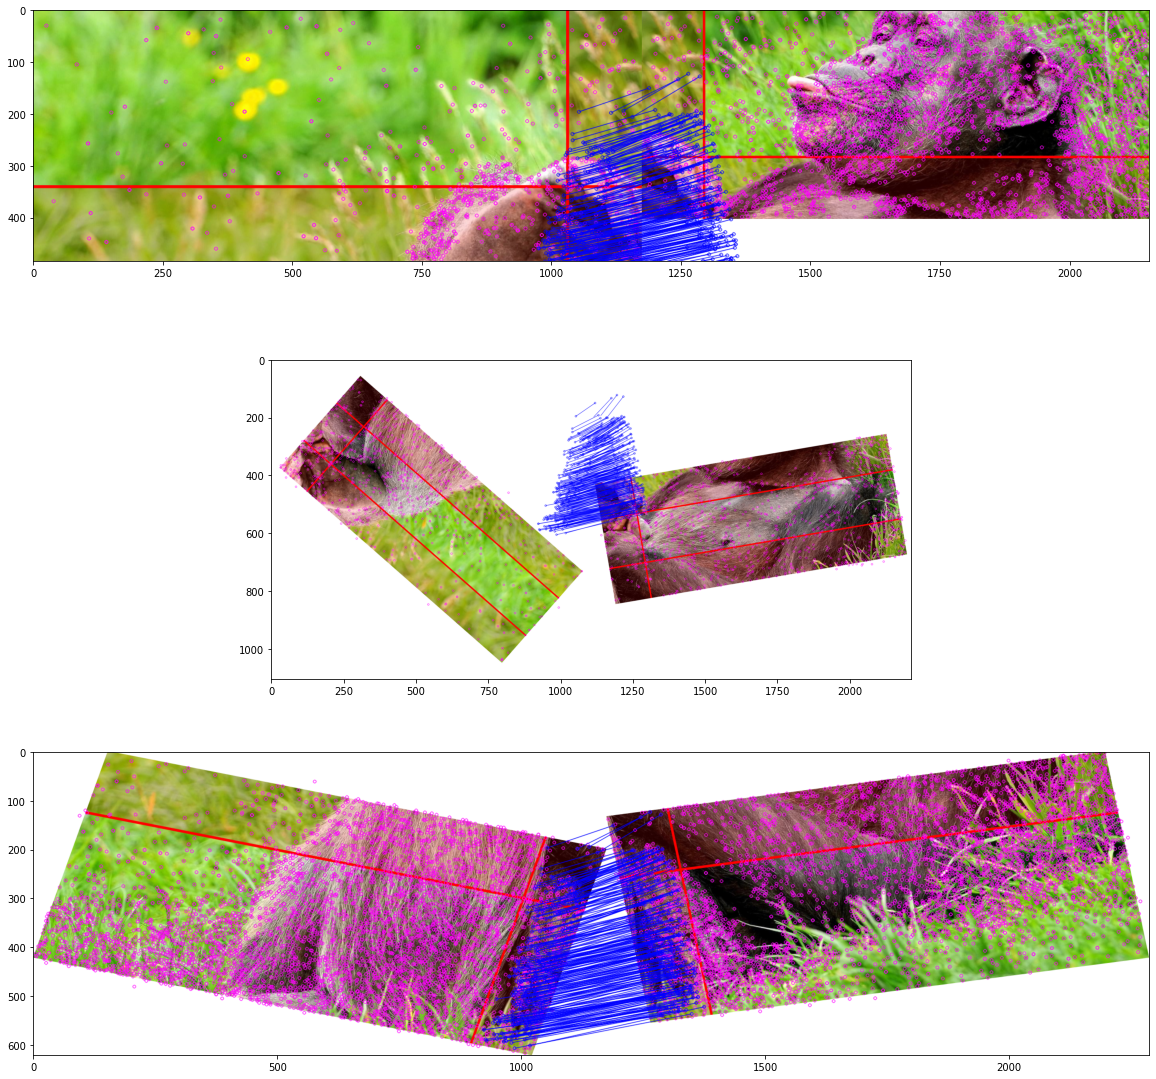

In [533]:
# register rows
_, axes = plt.subplots(r_split, 1, figsize=(20,20))
H_mats = []

for r, data in enumerate(sift_data):
    res, H = register(data, *splits[r])
    H_mats.append(H)
    axes[r].imshow(res)